# Introduction : Holmusk Dataset Challenge
<a id = 'top'></a>
___

<img src = 'image\maincover.jpg' width = 75%/>
img source : www.medicalbag.com

### Problem Statement
`Given a set of clinical data , might we be able to find insights about the key drivers on the cost of care?`


### Workflow Process

- [0.0 General Libraries](#section0)
- 0.5 General Function
- [1.0 File Import and Dataframe Preparation](#section1)
- [2.0 EDA & Insights](#section2)
- [3.0 In depth Insight](#section3)
- [4.0 Next Step](#section4)

### 0.0 Import Libraries
<a id = 'section0'></a>
___

In [1]:
import os
import datetime
from datetime import datetime

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

### 0.5 General Function
___

In [2]:
def file_info(df):
    
    """
    General info on dataframe number of rows , columns , total element and general header.
    
    """
    
    print('DF shape    :' , df.shape)
    print('DF size     :' , df.size)
    print()
    
    print(df.dtypes)
    print()
    
    display(df.head())

In [3]:
def id_eda(name , df):
    
    """
    To loop through the dataframe col , extract columns with 'id' and explore the number of unique id in those column.
    
    1. Extract columns with ID features.
    2. Check the number of unique ID for those features.
    
    """
    id_feature = [uid for uid in df.columns if 'id' in uid]
    
    for feature in id_feature:
        print(f'No. of Unique {feature} in {name}: {df[feature].nunique()}')

In [4]:
def EDA_subplot(nrows , ncols , feature_list , df , ylimit = None):

    plt.figure(figsize = (ncols*8 , nrows*12))
    for i in range(len(feature_list)):
        plt.subplot(nrows , ncols , i+1)
        
        # If numeric data feature , plot kdeplot
        if pd.api.types.is_numeric_dtype(df[feature_list[i]]):
        
            sns.kdeplot(data = df,
                        x = 'amount',
                        shade = True,
                        hue = feature_list[i])
            plt.title(f'{feature_list[i]} vs Bill Cost' , fontsize = 16)
            plt.xticks(rotation = 90 , fontsize = 10)
            plt.xlabel(xlabel = feature_list[i] , fontsize = 10)
            plt.ylabel(ylabel = 'Distribution' , fontsize = 10)
            plt.ylim(0 , ylimit)

In [5]:
def eval_pred(model , X_train, X_val):
    
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    
    scores = {'Training MAE': mean_absolute_error(y_train , train_pred),
              'Validation MAE' : mean_absolute_error(y_test , val_pred),
              'Training RMSE': mean_squared_error(y_train , train_pred , squared = False),
              'Validation RMSE' : mean_squared_error(y_test , val_pred , squared = False),
              'Training Model Score' : model.score(X_train, y_train),
              'Validation Model Score' : model.score(X_val , y_test)}
    
    
    df_score = pd.DataFrame({'Score' : scores.values()}, 
                              index = scores.keys())
    return df_score

### 1.0 File Import and Dataframe Preparation
<a id = 'section1'></a>
[back to top](#top)
___

* 1.1 Reading in File
* 1.2 Checking for Null
* 1.3 Exploring for unique duplicates
* 1.4 Merging Dataset

#### 1.1 Reading in File
[back to section 1](#section1)

In [6]:
for dirpath, dirnames, filenames in os.walk('data'):
    print(f'There are total of {len(filenames)} in {dirpath}')
    print(f'Name of file : {filenames}')

There are total of 4 in data
Name of file : ['bill_amount.csv', 'bill_id.csv', 'clinical_data.csv', 'demographics.csv']


In [7]:
df_bill_amt = pd.read_csv('data/bill_amount.csv')
df_bill_id = pd.read_csv('data/bill_id.csv')
df_clinical = pd.read_csv('data/clinical_data.csv')
df_demographic = pd.read_csv('data/demographics.csv')

df_file_dict = {'Bill_amount' : df_bill_amt , 
                'Bill_id' : df_bill_id , 
                'Clinical_data' : df_clinical , 
                'Demographics' : df_demographic}

In [8]:
for name , df in df_file_dict.items():
    print('File Name : ' , name)
    print('--------------------')
    file_info(df)
    print()

File Name :  Bill_amount
--------------------
DF shape    : (13600, 2)
DF size     : 27200

bill_id      int64
amount     float64
dtype: object



,bill_id,amount
0,40315104,1552.634830
1,2660045161,1032.011951
2,1148334643,6469.605351
3,3818426276,755.965425
4,9833541918,897.347816



File Name :  Bill_id
--------------------
DF shape    : (13600, 3)
DF size     : 40800

bill_id               int64
patient_id           object
date_of_admission    object
dtype: object



,bill_id,patient_id,date_of_admission
0,7968360812,1d21f2be18683991eb93d182d6b2d220,2011-01-01
1,6180579974,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01
2,7512568183,1d21f2be18683991eb93d182d6b2d220,2011-01-01
3,3762633379,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01
4,7654730355,1d21f2be18683991eb93d182d6b2d220,2011-01-01



File Name :  Clinical_data
--------------------
DF shape    : (3400, 26)
DF size     : 88400

id                     object
date_of_admission      object
date_of_discharge      object
medical_history_1       int64
medical_history_2     float64
medical_history_3      object
medical_history_4       int64
medical_history_5     float64
medical_history_6       int64
medical_history_7       int64
preop_medication_1      int64
preop_medication_2      int64
preop_medication_3      int64
preop_medication_4      int64
preop_medication_5      int64
preop_medication_6      int64
symptom_1               int64
symptom_2               int64
symptom_3               int64
symptom_4               int64
symptom_5               int64
lab_result_1          float64
lab_result_2          float64
lab_result_3          float64
weight                float64
height                float64
dtype: object



,id,date_of_admission,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,...,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height
0,1d21f2be18683991eb93d182d6b2d220,2011-01-01,2011-01-11,0,1.0,0,0,0.0,0,0,...,0,0,0,1,1,13.2,30.9,123.0,71.3,161.0
1,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01,2011-01-11,0,0.0,0,0,0.0,0,0,...,0,0,1,1,1,13.8,22.6,89.0,78.4,160.0
2,c85cf97bc6307ded0dd4fef8bad2fa09,2011-01-02,2011-01-13,0,0.0,0,0,0.0,0,0,...,1,1,1,1,0,11.2,26.2,100.0,72.0,151.0
3,e0397dd72caf4552c5babebd3d61736c,2011-01-02,2011-01-14,0,1.0,No,0,0.0,1,1,...,1,1,1,1,1,13.3,28.4,76.0,64.4,152.0
4,94ade3cd5f66f4584902554dff170a29,2011-01-08,2011-01-16,0,0.0,No,0,0.0,1,1,...,0,1,0,1,0,12.0,27.8,87.0,55.6,160.0



File Name :  Demographics
--------------------
DF shape    : (3000, 5)
DF size     : 15000

patient_id         object
gender             object
race               object
resident_status    object
date_of_birth      object
dtype: object



,patient_id,gender,race,resident_status,date_of_birth
0,fa2d818b2261e44e30628ad1ac9cc72c,Female,Indian,Singaporean,1971-05-14
1,5b6477c5de78d0b138e3b0c18e21d0ae,f,Chinese,Singapore citizen,1976-02-18
2,320aa16c61937447fd6631bf635e7fde,Male,Chinese,Singapore citizen,1982-07-03
3,c7f3881684045e6c49020481020fae36,Male,Malay,Singapore citizen,1947-06-15
4,541ad077cb4a0e64cc422673afe28aef,m,Chinese,Singaporean,1970-12-12


#### 1.2 Checking for Null
[back to section 1](#section1)

- From 4 csv file , only clinical data CSV has 537 null value
- Medical History 5 and Medical History 2 has null value
- Exploring the row that has null value.
- Replace Null with 0

In [9]:
for name , df in df_file_dict.items():
    print(f'Null value in {name} :' , df.isnull().sum().sum())
    print(f"Percentage null rows: {round(df.isnull().sum().sum() / df.shape[0] * 100, 2)}%")
    print()

Null value in Bill_amount : 0
Percentage null rows: 0.0%

Null value in Bill_id : 0
Percentage null rows: 0.0%

Null value in Clinical_data : 537
Percentage null rows: 15.79%

Null value in Demographics : 0
Percentage null rows: 0.0%



In [10]:
# Checking the top few features that has null value in clinical data

df_clinical.isnull().sum().sort_values(ascending = False)[:5]

medical_history_5    304
medical_history_2    233
height                 0
weight                 0
date_of_admission      0
dtype: int64

In [11]:
# Visualising Rows that has null values

df_clinical[df_clinical['medical_history_5'].isnull() | df_clinical['medical_history_2'].isnull()][:5]

,id,date_of_admission,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,...,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height
5,59e07adc2dbc5f70131f57d003610d74,2011-01-07,2011-01-17,0,NaN,No,0,NaN,0,0,...,1,0,1,1,1,15.8,31.0,75.0,78.8,169.0
10,d45fcf3bec63ae3b436be42fad33b9e0,2011-01-12,2011-01-18,1,NaN,No,1,0.0,0,0,...,1,1,0,1,0,17.0,27.7,116.0,91.6,169.0
14,c59af905597b9be72420bbdbdad2ce42,2011-01-10,2011-01-22,0,NaN,0,0,NaN,0,0,...,1,1,1,1,0,15.6,30.9,87.0,71.1,177.0
20,7ce28b0d1309e0a2a74e38747ebd3f6c,2011-01-11,2011-01-25,0,NaN,No,0,0.0,1,0,...,0,0,0,0,1,14.0,31.3,123.0,88.0,151.0
22,c9809bb40710a9079848f06d47ef980b,2011-01-14,2011-01-25,0,NaN,1,0,0.0,0,0,...,0,1,1,1,1,15.2,25.2,70.0,79.1,167.0


In [12]:
df_clinical.fillna(0 , inplace = True)

#### 1.3 Exploring Unique Values in Features
[back to section 1](#section1)

- There are 13600 patient visit
- There are 3000 Patient ID

In [13]:
for name , df in df_file_dict.items():
    id_eda(name , df)

No. of Unique bill_id in Bill_amount: 13600
No. of Unique bill_id in Bill_id: 13600
No. of Unique patient_id in Bill_id: 3000
No. of Unique id in Clinical_data: 3000
No. of Unique patient_id in Demographics: 3000
No. of Unique resident_status in Demographics: 4


#### 1.4 Merging Datasets
[back to section 1](#section1)

- 1.4.1 Standardise String Values in dataframe
- 1.4.2 Merging dataframes
- 1.4.3 Standardise column datatype

#### 1.4.1 Standardise String Values in  dataframe
- Demographic Dataframe : Standardise Gender , Race & resident Status
- Clinical Dataframe : Standardise Medical History 3

In [14]:
# Checking Values before replacing
for col in df_demographic.drop(['patient_id' , 'date_of_birth'] , axis = 1):
    print(f' Unique Value in {col} name Before Replace : {df_demographic[col].unique()}')

replace_dict = {'f' : 'Female',
                'm' : 'Male',
                'chinese' : 'Chinese',
                'India' : 'Indian',
                'Singapore citizen' : 'Singaporean'}

df_demographic.replace(replace_dict , inplace=True)


# Checking Values after replacing
for col in df_demographic.drop(['patient_id' , 'date_of_birth'] , axis = 1):
    print(f' Unique Value in {col} name After Replace : {df_demographic[col].unique()}')

 Unique Value in gender name Before Replace : ['Female' 'f' 'Male' 'm']
 Unique Value in race name Before Replace : ['Indian' 'Chinese' 'Malay' 'chinese' 'India' 'Others']
 Unique Value in resident_status name Before Replace : ['Singaporean' 'Singapore citizen' 'PR' 'Foreigner']
 Unique Value in gender name After Replace : ['Female' 'Male']
 Unique Value in race name After Replace : ['Indian' 'Chinese' 'Malay' 'Others']
 Unique Value in resident_status name After Replace : ['Singaporean' 'PR' 'Foreigner']


In [15]:
print(f'Unique Value Before Replace : {df_clinical["medical_history_3"].unique()}')

replace_dict = {'No' : '0',
                'Yes' : '1'}
df_clinical['medical_history_3'].replace(replace_dict , inplace=True)

print(f'Unique Value After Replace : {df_clinical["medical_history_3"].unique()}')

Unique Value Before Replace : ['0' 'No' '1' 'Yes']
Unique Value After Replace : ['0' '1']


#### 1.4.2 Merging DataFrame

In [16]:
# Merging Bill Amount and Bill Id - Common Bill Id
df_bill = pd.merge(df_bill_amt,
                   df_bill_id,
                   left_on = 'bill_id',
                   right_on = 'bill_id')

In [17]:
file_info(df_bill)

DF shape    : (13600, 4)
DF size     : 54400

bill_id                int64
amount               float64
patient_id            object
date_of_admission     object
dtype: object



,bill_id,amount,patient_id,date_of_admission
0,40315104,1552.634830,96a76ec5bbcb1d1562c40b9b972e356d,2012-10-22
1,2660045161,1032.011951,796de06efdad342d3f3a379dff0bd63c,2014-09-28
2,1148334643,6469.605351,1ce104904e9160cf3cfdb3c45b9ce4ff,2014-01-16
3,3818426276,755.965425,afdfe7216d84e13708a19cbca288379a,2013-01-22
4,9833541918,897.347816,b9a0c119dc07e07f88281964f3a4869f,2011-04-22


In [18]:
# Merging With Clinical - Common Patient Id

df_main = pd.merge(df_bill,
                   df_clinical,
                   left_on = ['patient_id' , 'date_of_admission'],
                   right_on = ['id' , 'date_of_admission'])

# Merging With Demographic - Common Patient Id

df_main = df_main.merge(df_demographic,
                        left_on = 'patient_id',
                        right_on = 'patient_id')

file_info(df_main)

DF shape    : (13600, 33)
DF size     : 448800

bill_id                 int64
amount                float64
patient_id             object
date_of_admission      object
id                     object
date_of_discharge      object
medical_history_1       int64
medical_history_2     float64
medical_history_3      object
medical_history_4       int64
medical_history_5     float64
medical_history_6       int64
medical_history_7       int64
preop_medication_1      int64
preop_medication_2      int64
preop_medication_3      int64
preop_medication_4      int64
preop_medication_5      int64
preop_medication_6      int64
symptom_1               int64
symptom_2               int64
symptom_3               int64
symptom_4               int64
symptom_5               int64
lab_result_1          float64
lab_result_2          float64
lab_result_3          float64
weight                float64
height                float64
gender                 object
race                   object
resident_status       

,bill_id,amount,patient_id,date_of_admission,id,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,...,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height,gender,race,resident_status,date_of_birth
0,40315104,1552.634830,96a76ec5bbcb1d1562c40b9b972e356d,2012-10-22,96a76ec5bbcb1d1562c40b9b972e356d,2012-11-03,0,0.0,0,0,...,1,17.6,31.8,98.0,65.1,166.0,Female,Malay,Singaporean,1967-05-15
1,7040712549,27923.446312,96a76ec5bbcb1d1562c40b9b972e356d,2012-10-22,96a76ec5bbcb1d1562c40b9b972e356d,2012-11-03,0,0.0,0,0,...,1,17.6,31.8,98.0,65.1,166.0,Female,Malay,Singaporean,1967-05-15
2,1314727123,1952.978141,96a76ec5bbcb1d1562c40b9b972e356d,2012-10-22,96a76ec5bbcb1d1562c40b9b972e356d,2012-11-03,0,0.0,0,0,...,1,17.6,31.8,98.0,65.1,166.0,Female,Malay,Singaporean,1967-05-15
3,1029762870,1244.994422,96a76ec5bbcb1d1562c40b9b972e356d,2012-10-22,96a76ec5bbcb1d1562c40b9b972e356d,2012-11-03,0,0.0,0,0,...,1,17.6,31.8,98.0,65.1,166.0,Female,Malay,Singaporean,1967-05-15
4,2660045161,1032.011951,796de06efdad342d3f3a379dff0bd63c,2014-09-28,796de06efdad342d3f3a379dff0bd63c,2014-10-11,0,0.0,0,0,...,0,16.3,29.1,94.0,72.5,162.0,Female,Chinese,Singaporean,1973-05-28


#### 1.4.3 Standardising Datatype

- Convert Datetime column to datetime format
- Created BMI , Stay-In Day , age
- Created col for total count of symptom and total count of medical history
- Drop duplicate column (id) , remove discharge and admission day and birthday/

In [19]:
med_history = [col for col in df_main if 'history' in col]
symptom = [col for col in df_main if 'symptom' in col]
preop_med = [col for col in df_main if 'medication' in col]
lab_result = [col for col in df_main if 'lab' in col]

In [20]:
current_year =  datetime.now().year

df_main['date_of_admission'] = df_main['date_of_admission'].astype('datetime64[ns]')
df_main['date_of_discharge'] = df_main['date_of_discharge'].astype('datetime64[ns]')
df_main['date_of_birth'] = df_main['date_of_birth'].astype('datetime64[ns]')
df_main['medical_history_2'] = df_main['medical_history_2'].astype('int64')
df_main['medical_history_3'] = df_main['medical_history_3'].astype('int64')
df_main['medical_history_5'] = df_main['medical_history_5'].astype('int64')

df_main['stayin_day'] = (df_main['date_of_discharge'] - df_main['date_of_admission']).dt.days
df_main['BMI'] = df_main['weight'] / (df_main['height']/100)**2
df_main['total_medical_history'] = df_main[med_history].sum(axis = 1)

df_main['total_symptom'] = df_main[symptom].sum(axis = 1)
df_main['total_preop_med'] = df_main[preop_med].sum(axis = 1)

df_main['age'] = current_year - df_main['date_of_birth'].dt.year

df_main.drop(['id' , 'date_of_discharge' , 'date_of_admission' , 'date_of_birth'], axis = 1 , inplace = True)

## Transforming the amount does not help much
# df_main['amount_sqrt'] = df_main['amount']**0.5
# df_main['amount_sq'] = df_main['amount']**2
# df_main['amount_log'] = np.log(df_main['amount'])

In [21]:
file_info(df_main)

DF shape    : (13600, 35)
DF size     : 476000

bill_id                    int64
amount                   float64
patient_id                object
medical_history_1          int64
medical_history_2          int64
medical_history_3          int64
medical_history_4          int64
medical_history_5          int64
medical_history_6          int64
medical_history_7          int64
preop_medication_1         int64
preop_medication_2         int64
preop_medication_3         int64
preop_medication_4         int64
preop_medication_5         int64
preop_medication_6         int64
symptom_1                  int64
symptom_2                  int64
symptom_3                  int64
symptom_4                  int64
symptom_5                  int64
lab_result_1             float64
lab_result_2             float64
lab_result_3             float64
weight                   float64
height                   float64
gender                    object
race                      object
resident_status           ob

,bill_id,amount,patient_id,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,...,height,gender,race,resident_status,stayin_day,BMI,total_medical_history,total_symptom,total_preop_med,age
0,40315104,1552.634830,96a76ec5bbcb1d1562c40b9b972e356d,0,0,0,0,0,0,1,...,166.0,Female,Malay,Singaporean,12,23.624619,1,5,4,55
1,7040712549,27923.446312,96a76ec5bbcb1d1562c40b9b972e356d,0,0,0,0,0,0,1,...,166.0,Female,Malay,Singaporean,12,23.624619,1,5,4,55
2,1314727123,1952.978141,96a76ec5bbcb1d1562c40b9b972e356d,0,0,0,0,0,0,1,...,166.0,Female,Malay,Singaporean,12,23.624619,1,5,4,55
3,1029762870,1244.994422,96a76ec5bbcb1d1562c40b9b972e356d,0,0,0,0,0,0,1,...,166.0,Female,Malay,Singaporean,12,23.624619,1,5,4,55
4,2660045161,1032.011951,796de06efdad342d3f3a379dff0bd63c,0,0,0,0,0,0,0,...,162.0,Female,Chinese,Singaporean,13,27.625362,0,3,5,49


# 2.0 EDA & Insights
<a id = 'section2'></a>
[back to top](#top)

In this section , before we explore the data in depth , there are some general questions i would like to understand further before going more in depth :

- 2.1 What are the general demographic like and do foreigner pay more?
- 2.2 What is the age distribution like and do older people have more medical history or symptom?
- 2.3 Clinical Data on Cost of Operation

In [22]:
agg_dict = {'bill_id' : 'count',
            'amount' : np.sum,
            'medical_history_1' : np.max,
            'medical_history_2' : np.max,
            'medical_history_3' : np.max,
            'medical_history_4' : np.max,
            'medical_history_5' : np.max,
            'medical_history_6' : np.max,
            'medical_history_7' : np.max,
            'preop_medication_1' : np.max,
            'preop_medication_2' : np.max,
            'preop_medication_3' : np.max,
            'preop_medication_4' : np.max,
            'preop_medication_5' : np.max,
            'preop_medication_6' : np.max,
            'symptom_1' : np.max,
            'symptom_2' : np.max,
            'symptom_3' : np.max,
            'symptom_4' : np.max,
            'symptom_5' : np.max,
            'lab_result_1' : np.mean,
            'lab_result_2' : np.mean,
            'lab_result_3' : np.mean,
            'weight' : np.mean,
            'height' : np.mean,
            'stayin_day' : np.mean,
            'BMI' : np.mean,
            'total_medical_history' : np.mean}

df_group = df_main.groupby('patient_id').agg(agg_dict).sort_values(by = 'amount' , ascending = False)

### 2.1 General Overview on Patient Demographic
___

- Most of the sample sizes are from locals, and remaining 20% are PR and foreigner.
- Male and Female are equal in sample size
- Foreigner typically pay more (2x and PR 1.1x)

In [23]:
df_main['gender'].value_counts()

Female    6808
Male      6792
Name: gender, dtype: int64

In [24]:
df_main['resident_status'].value_counts(normalize=True)

Singaporean    0.801176
PR             0.151471
Foreigner      0.047353
Name: resident_status, dtype: float64

In [25]:
df_main.groupby('resident_status').describe()['amount']

,count,mean,std,min,25%,50%,75%,max
resident_status,,,,,,,,
Foreigner,644.0,10425.943808,14338.418741,654.574997,1831.753355,2778.934645,14529.994149,81849.751340
PR,2060.0,6092.514504,8248.060037,278.231612,1091.480095,1723.124592,8324.254423,47120.256963
Singaporean,10896.0,5052.859228,6903.044232,79.496707,909.136936,1406.275189,6929.723406,42454.689976


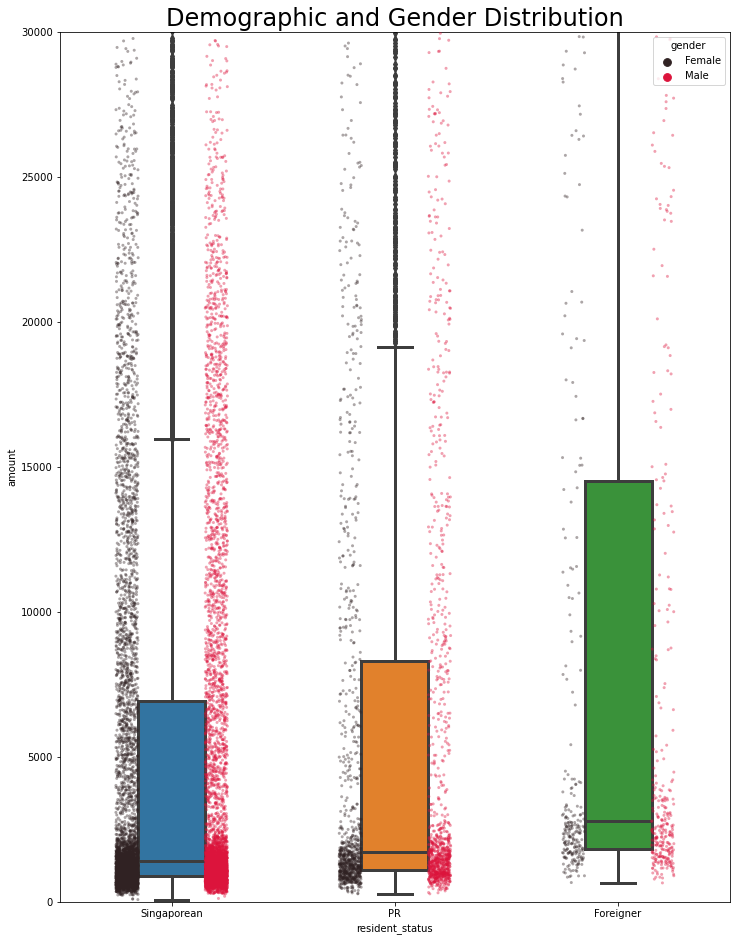

In [26]:
plt.figure(figsize = (12,16))

sns.boxplot(x = 'resident_status',
            y = 'amount',
            data = df_main,
            linewidth = 3,
            width = 0.3)


sns.stripplot(x = 'resident_status',
              y = 'amount',
              data = df_main,
              color = 'crimson',
              alpha = 0.4,
              size = 3,
              dodge = True,
              hue = 'gender')

plt.ylim(0 , 30000)

plt.title('Demographic and Gender Distribution' , fontsize = 24);

### 2.2 What is the _age distribution_ like and do older people have more medical history or symptom?
___

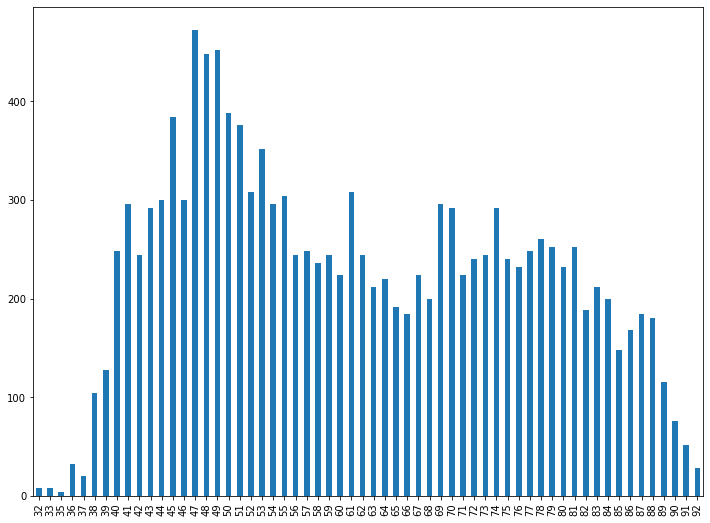

In [27]:
df_main['age'].value_counts().sort_index().plot(kind = 'bar' , figsize = (12,9));

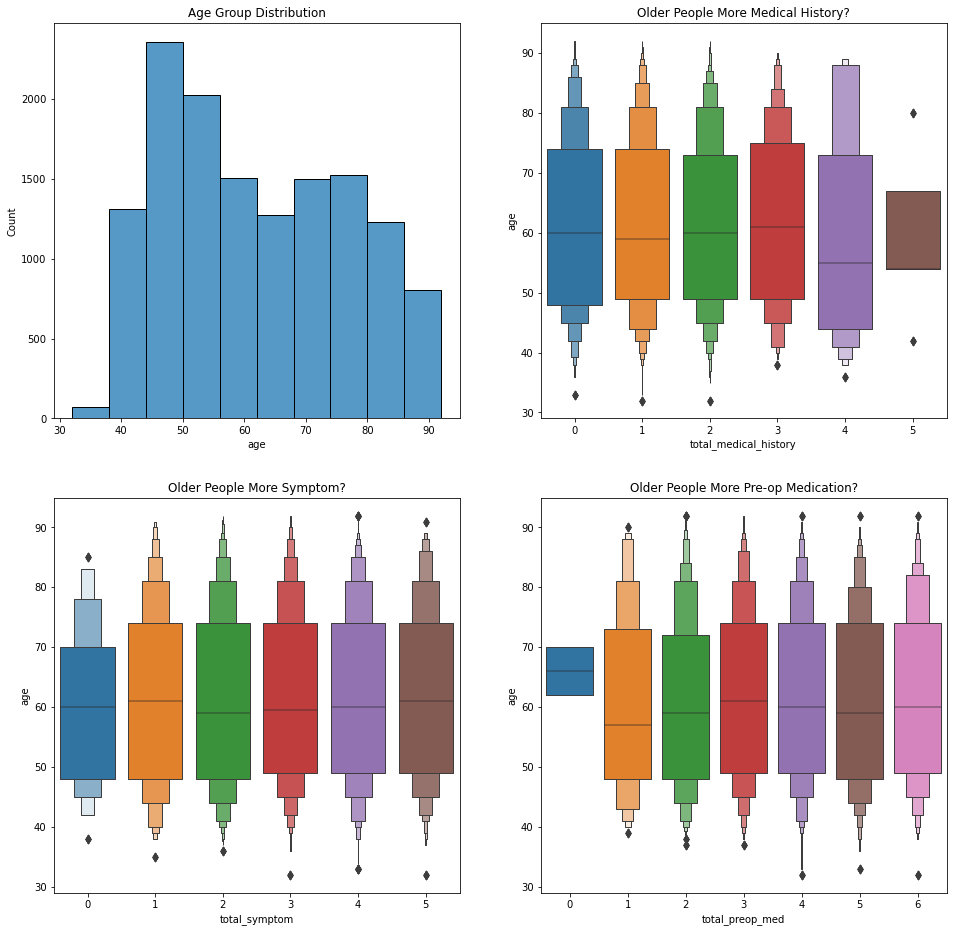

In [28]:
fig ,ax = plt.subplots(2,2 , figsize = (16,16))

sns.histplot(df_main['age'] , 
             bins = 10 , 
             ax = ax[0,0])
ax[0,0].set_title('Age Group Distribution');


sns.boxenplot(data=df_main, 
              x='total_medical_history', 
              y='age',
              ax = ax[0,1])
ax[0,1].set_title('Older People More Medical History?')

sns.boxenplot(data=df_main, 
              x='total_symptom', 
              y='age',
              ax = ax[1,0])
ax[1,0].set_title('Older People More Symptom?')

sns.boxenplot(data=df_main, 
              x='total_preop_med', 
              y='age',
              ax = ax[1,1])
ax[1,1].set_title('Older People More Pre-op Medication?')

plt.show()

### 2.3 Clinical Data on Cost of Operation
___

- If a patient have more instances of medical history , does this complicate the treatment and increase the cost?
- What about having more symptom or preop medication?
- Does a patient BMI correlate to more medical history or more symptoms or more preop medication?

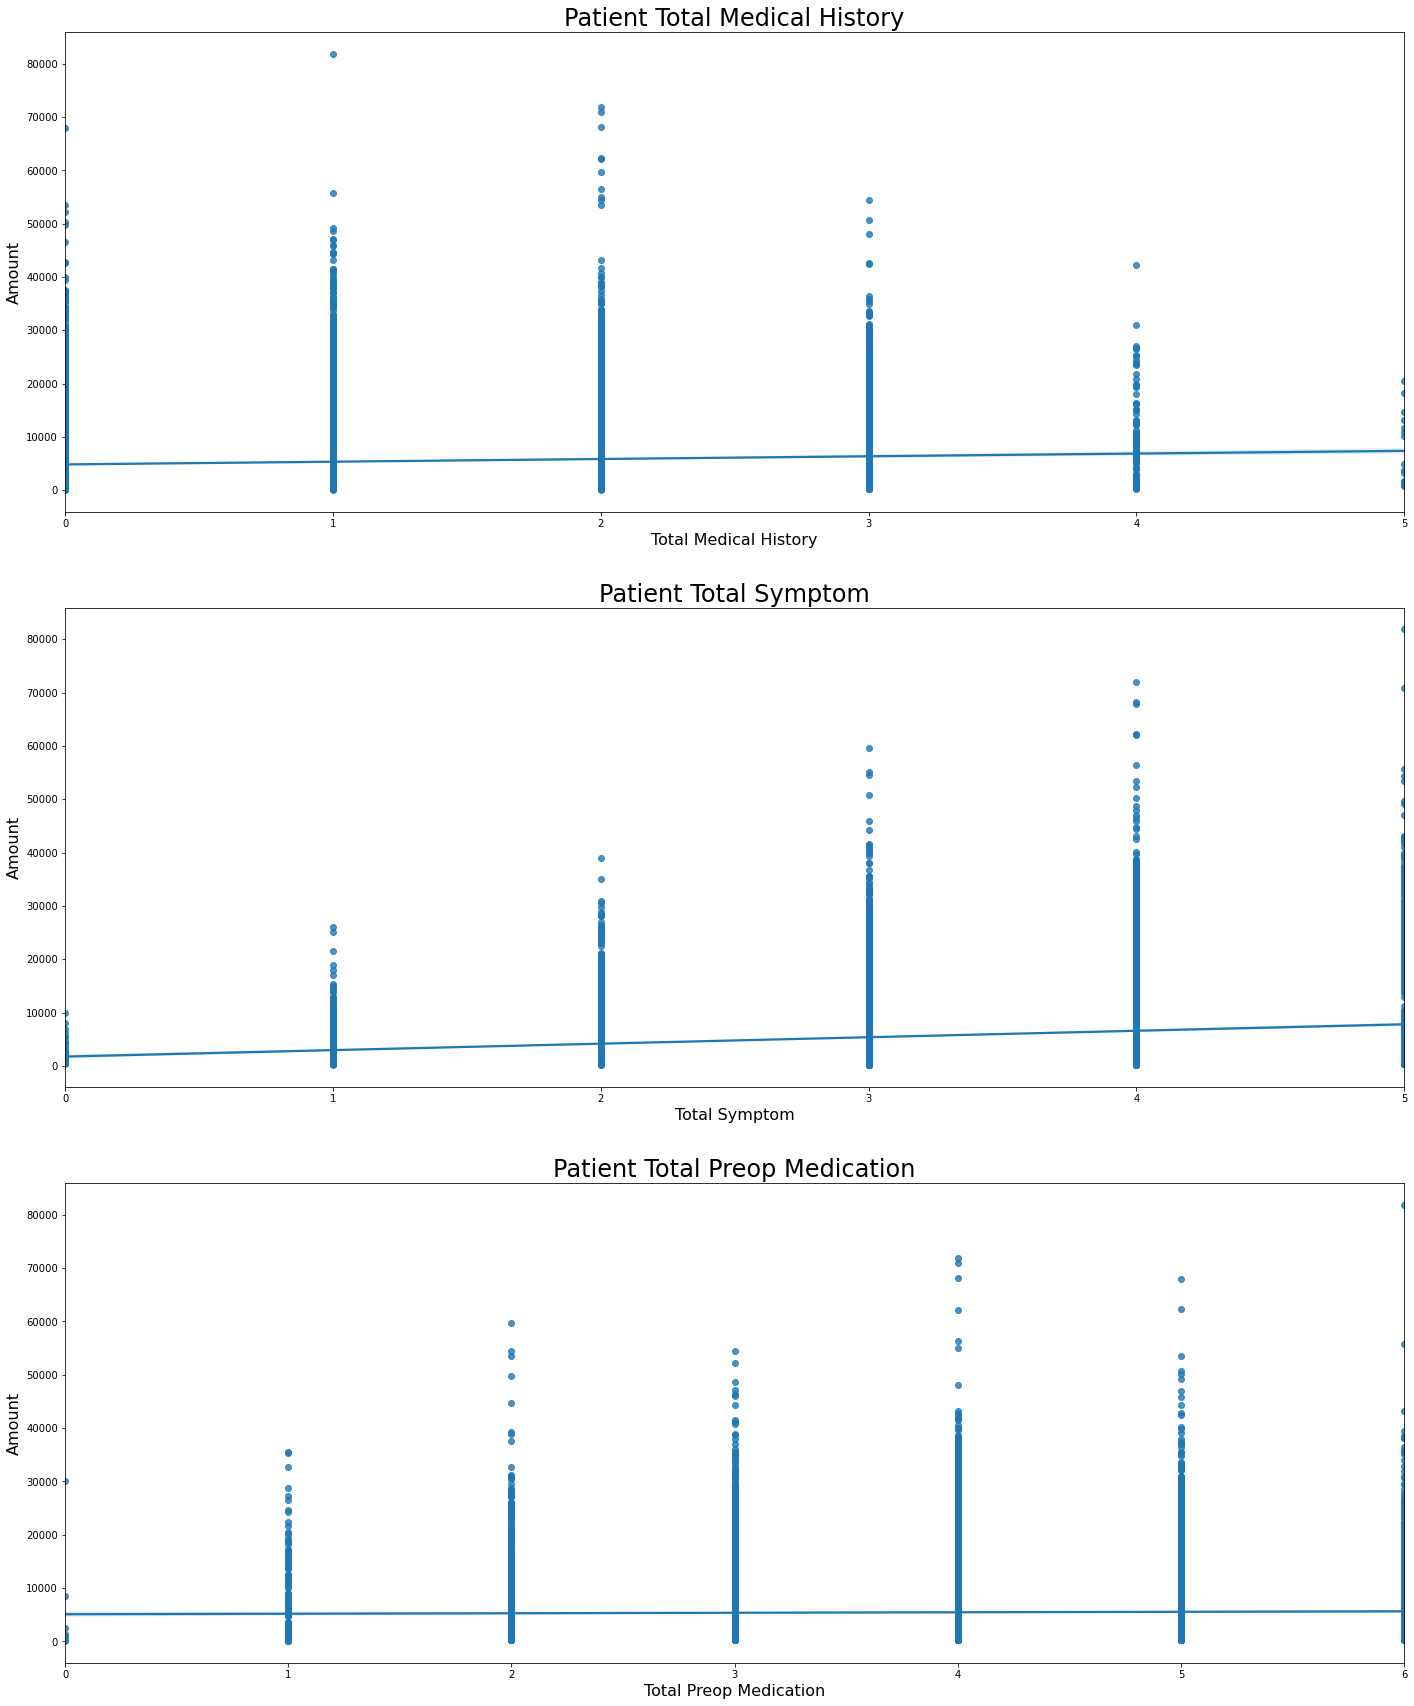

In [29]:
plt.figure(figsize = (24,30))

plt.subplot(3,1,1)
sns.regplot(x = 'total_medical_history',
              y = 'amount',
              data = df_main)
plt.title('Patient Total Medical History' , fontsize = 24)
plt.xlabel('Total Medical History' , fontsize = 16)
plt.ylabel('Amount' , fontsize = 16)

plt.subplot(3,1,2)
sns.regplot(x = 'total_symptom',
              y = 'amount',
              data = df_main)
plt.title('Patient Total Symptom' , fontsize = 24)
plt.xlabel('Total Symptom' , fontsize = 16)
plt.ylabel('Amount' , fontsize = 16)

plt.subplot(3,1,3)
sns.regplot(x = 'total_preop_med',
              y = 'amount',
              data = df_main)
plt.title('Patient Total Preop Medication' , fontsize = 24)
plt.xlabel('Total Preop Medication' , fontsize = 16)
plt.ylabel('Amount' , fontsize = 16)

plt.show()

In [30]:
df_main['BMI_cat'] = df_main['BMI']

for index , values in enumerate(df_main['BMI']):
    if values < 18.5:
        df_main.loc[index , 'BMI_cat'] = 'Underweight'
    elif values >= 18.5 and values <24.9:
        df_main.loc[index , 'BMI_cat'] = 'Normal'
    elif values >= 24.9 and values <29.9:
        df_main.loc[index, 'BMI_cat'] = 'Overweight'
    elif values >= 29.9 and values <39.9:
        df_main.loc[index, 'BMI_cat'] = 'Severe Obesity'
    else:
        df_main.loc[index, 'BMI_cat'] = 'Extreme Obesity'

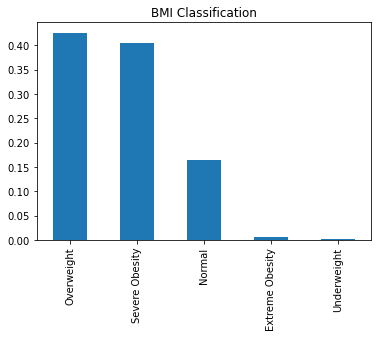

In [31]:
df_main['BMI_cat'].value_counts(normalize = True).plot(kind = 'bar');
plt.title('BMI Classification');

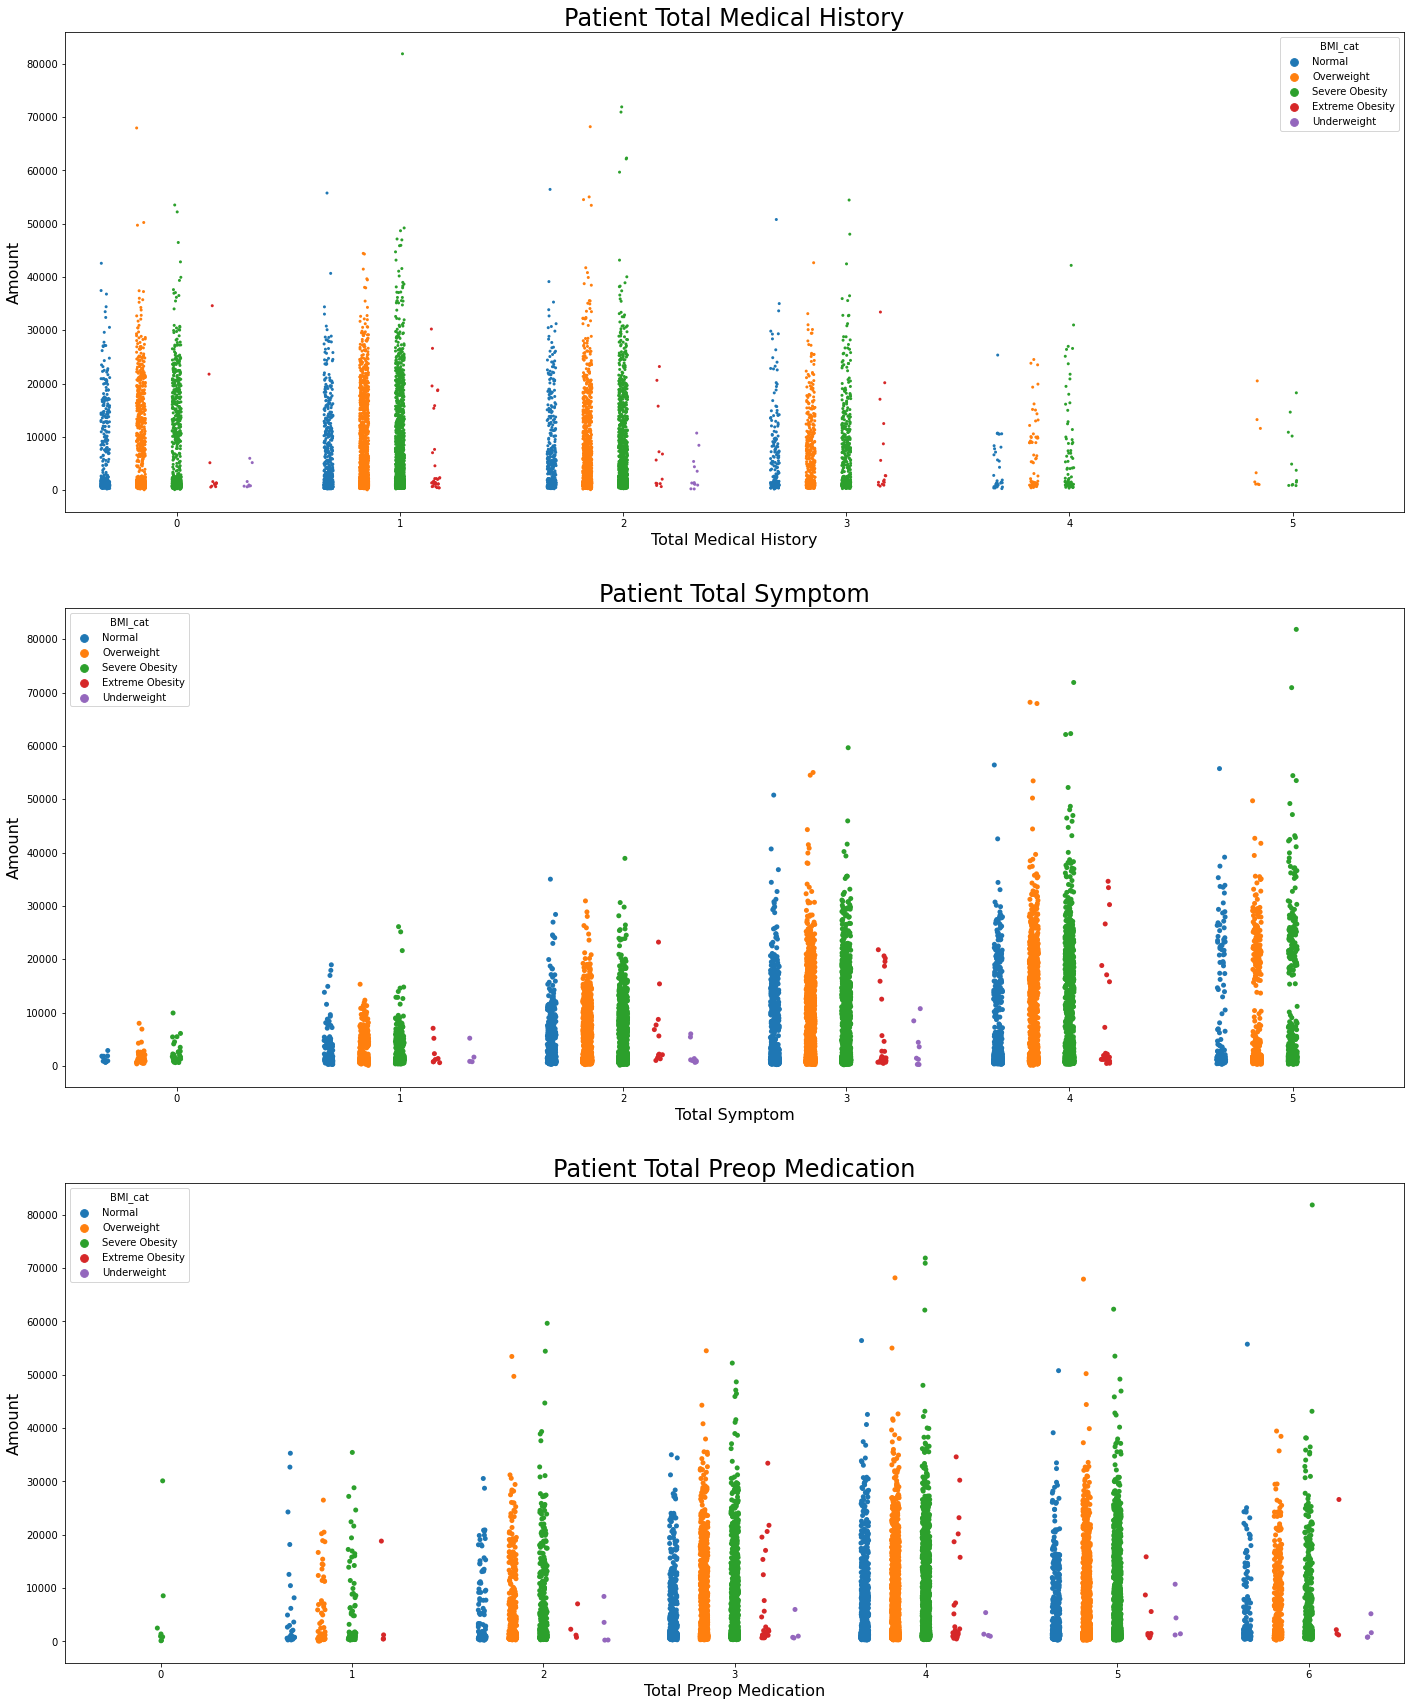

In [32]:
plt.figure(figsize = (24,30))

plt.subplot(3,1,1)
sns.stripplot(x = 'total_medical_history',
              y = 'amount',
              data = df_main,
              hue = 'BMI_cat',
              dodge = True,
              size = 3)
plt.title('Patient Total Medical History' , fontsize = 24)
plt.xlabel('Total Medical History' , fontsize = 16)
plt.ylabel('Amount' , fontsize = 16)

plt.subplot(3,1,2)
sns.stripplot(x = 'total_symptom',
              y = 'amount',
              data = df_main,
              hue = 'BMI_cat',
              dodge = True)
plt.title('Patient Total Symptom' , fontsize = 24)
plt.xlabel('Total Symptom' , fontsize = 16)
plt.ylabel('Amount' , fontsize = 16)

plt.subplot(3,1,3)
sns.stripplot(x = 'total_preop_med',
              y = 'amount',
              data = df_main,
              hue = 'BMI_cat',
              dodge = True)
plt.title('Patient Total Preop Medication' , fontsize = 24)
plt.xlabel('Total Preop Medication' , fontsize = 16)
plt.ylabel('Amount' , fontsize = 16)

plt.show()

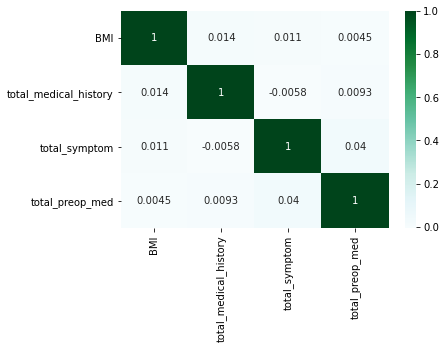

In [33]:
sns.heatmap(df_main[['BMI' , 'total_medical_history' , 'total_symptom' , 'total_preop_med']].corr(),
            annot = True,
            cmap = 'BuGn');

# 3.0 Indepth Insight
<a id = 'section3'></a>
[back to top](#top)
___

- 3.0 Statsmodel Linear Regression
- 3.1 Overall correlation studies between feature
- 3.2 Polynomial feature study on lab result
- 3.3 Data analysis on Clinical Data
- 3.4 Random Forest Feature Importance

In [34]:
import statsmodels.api as sm


X = df_main.drop(['amount' , 'bill_id', 'patient_id' , 'gender' , 'race' , 'resident_status' , 'BMI_cat'] , axis = 1)
y = df_main['amount']

X = sm.add_constant(X, prepend=True)
results = sm.OLS(y, X).fit()

In [35]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amount   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     33.96
Date:                Fri, 07 Jan 2022   Prob (F-statistic):          9.81e-164
Time:                        21:49:25   Log-Likelihood:            -1.4061e+05
No. Observations:               13600   AIC:                         2.813e+05
Df Residuals:                   13573   BIC:                         2.815e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -8205.9364   1.13e+04     -0.729      0.466   -3.03e+04    1.39e+04
medical_history_1      1107.2707    162.446      6.816      0.000     788.854    1425.687
medical_history_2      -267.7857    142.354     -1.881      0.060    -546.820      11.249
medical_history_3      -352.2199    175.598     -2.006      0.045    -696.415      -8.024
medical_history_4      -422.6057    259.823     -1.627      0.104    -931.895      86.684
medical_history_5        27.5327    247.526      0.111      0.911    -457.653     512.719
medical_history_6       437.8925    143.836      3.044      0.002     155.954     719.830
medical_history_7      -120.7086    144.195     -0.837      0.403    -403.351     161.934
preop_medication_1      -21.4969    119.865     -0.179      0.858    -256.448     213.454
preop_medication_2       -2.7318    121.791     -0.022      0.982    -241.459     235.996
preop_medication_3       74.3370    151.091      0.492      0.623    -221.822     370.496
preop_medication_4       22.0708    121.309      0.182      0.856    -215.711     259.853
preop_medication_5      -49.8549    151.448     -0.329      0.742    -346.714     247.004
preop_medication_6       34.6278    133.736      0.259      0.796    -227.513     296.769
symptom_1              -379.1812    120.272     -3.153      0.002    -614.932    -143.431
symptom_2               -24.2227    120.538     -0.201      0.841    -260.493     212.048
symptom_3               -33.9878    116.027     -0.293      0.770    -261.417     193.442
symptom_4              -219.0170    128.178     -1.709      0.088    -470.263      32.229
symptom_5              1630.4166    117.606     13.863      0.000    1399.892    1860.941
lab_result_1            -12.5087     36.822     -0.340      0.734     -84.685      59.668
lab_result_2             17.1150     26.133      0.655      0.513     -34.109      68.339
lab_result_3              1.0684      4.222      0.253      0.800      -7.207       9.343
weight                   11.4079     70.760      0.161      0.872    -127.292     150.108
height                   16.0085     68.095      0.235      0.814    -117.467     149.484
stayin_day                3.2526     22.623      0.144      0.886     -41.091      47.597
BMI                      66.2639    191.265      0.346      0.729    -308.642     441.170
total_medical_history   409.3760     67.283      6.084      0.000     277.493     541.259
total_symptom           974.0078     50.431     19.314      0.000     875.157    1072.859
total_preop_med          56.9519     51.160      1.113      0.266     -43.329     157.233
age                      56.1887      4.406     12.753      0.000      47.552      64.825
==============================================================================
Omnibus:                     5582.

In [36]:
top20 = np.quantile(df_main['amount'],0.8)
df_top20 = df_main[df_main['amount'] >= top20]

top1 = np.quantile(df_main['amount'],0.99)
df_top1 = df_main[df_main['amount'] >= top1]

df_local = df_main.loc[df_main['resident_status'] == 'Singaporean']
df_local_top1 = df_local[df_local['amount'] >= top1]

#### 3.1 Overall Heatmap on feature correlations
___

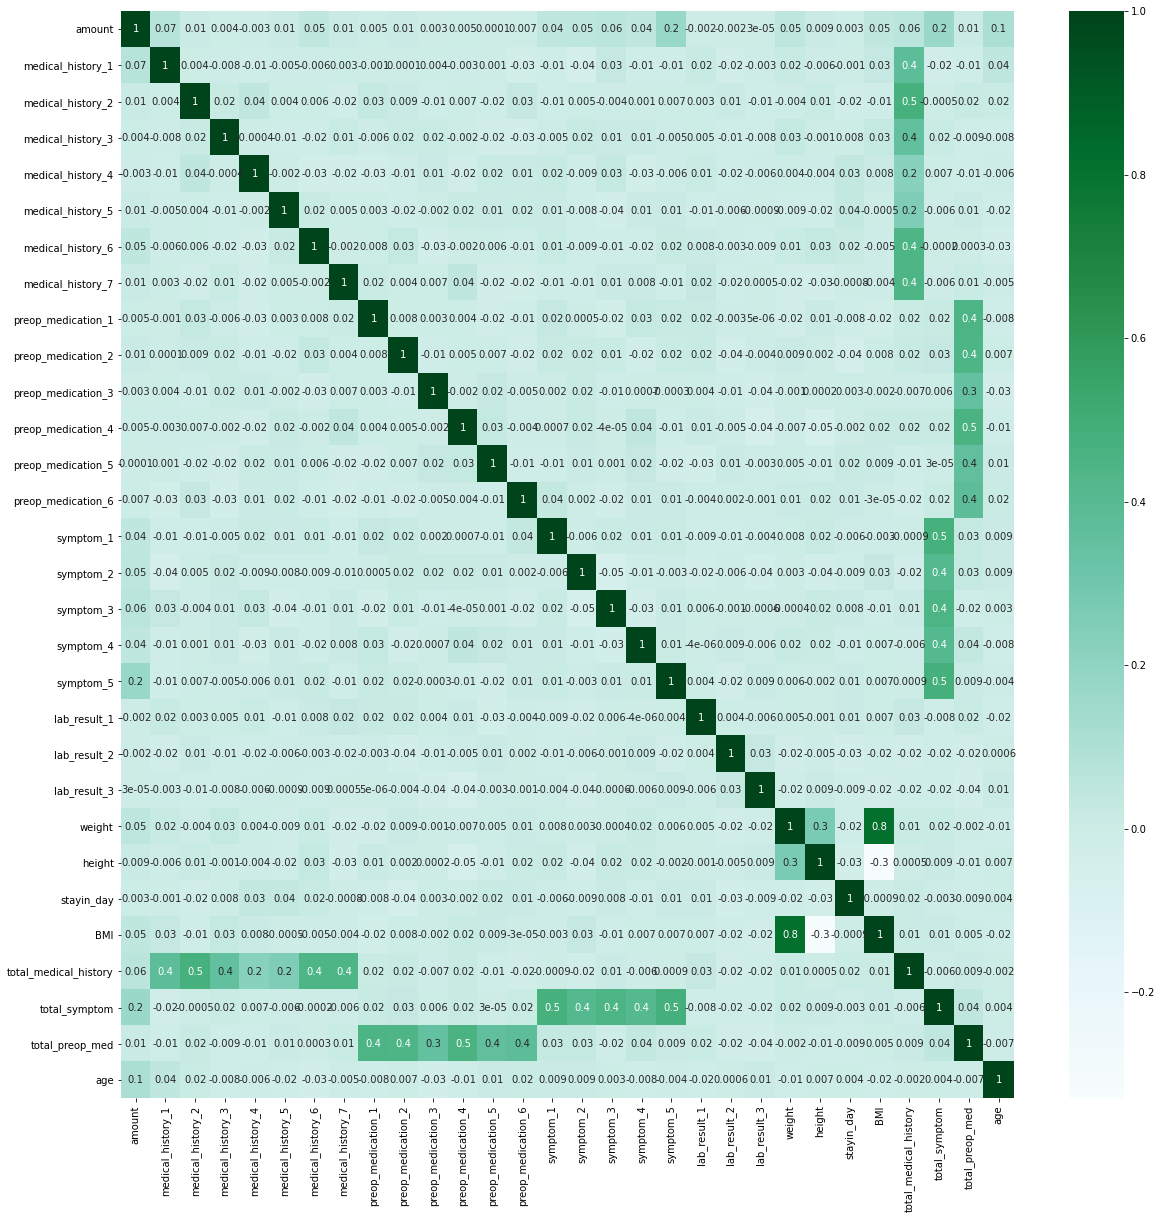

In [37]:
plt.figure(figsize = (20,20))
sns.heatmap(df_main.drop('bill_id' , axis = 1).corr(),
            cmap = 'BuGn',
            annot = True,
            fmt = '.1g');

#### 3.2 Overall Heatmap on lab results polynomial features
___

- No clear Indications that lab results and various polynomial feature of the lab results combination give a strong correlation with regards to the costs.

In [38]:
lab_result_amount = lab_result.copy()
lab_result_amount.append('amount')

# symptom_amount = symptom.copy()
# symptom_amount.append('amount')

# plt.figure(figsize = (12,9))
# sns.heatmap(df_main[symptom_amount].corr(),
#             cmap = 'BuGn',
#             annot = True)

# med_history.append('amount')

# plt.figure(figsize = (12,9))
# sns.heatmap(df_group[med_history].corr(),
#             cmap = 'BuGn',
#             annot = True)

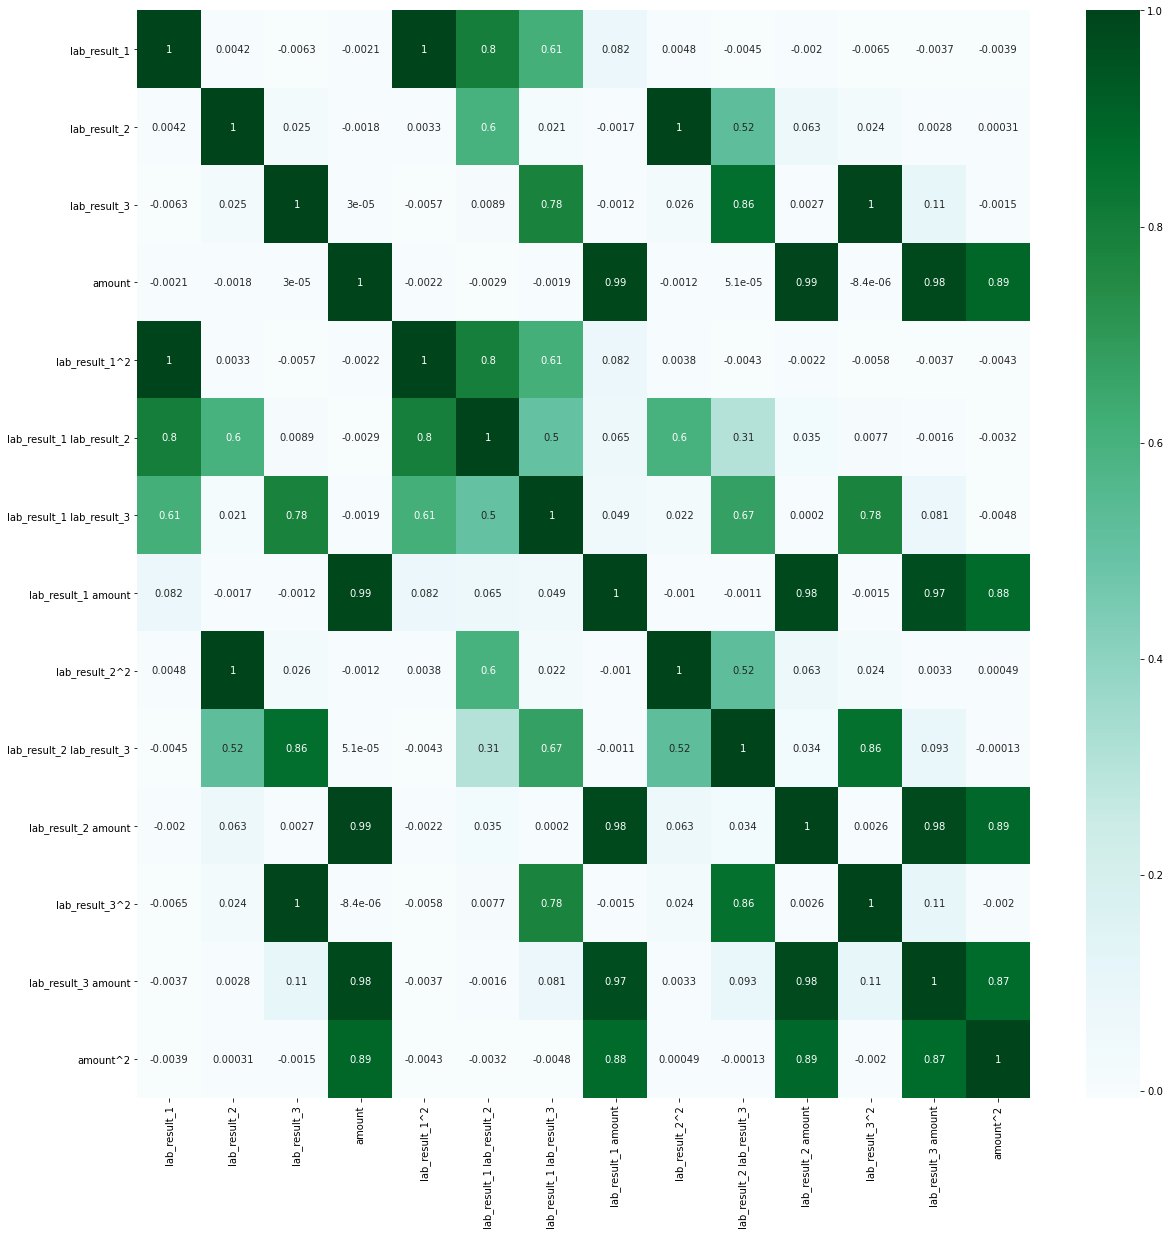

In [39]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

poly = PolynomialFeatures(include_bias=False)

X_poly = poly.fit_transform(df_main[lab_result_amount])

j = pd.DataFrame(X_poly , columns=poly.get_feature_names(lab_result_amount))

plt.figure(figsize = (20,20))

sns.heatmap(j.corr(),
            annot = True,
           cmap = 'BuGn' );

### 3.3 Data Analysis on Clinical Data
___

- Over here , we explore various clinical data and zoom into the individual clinical feature

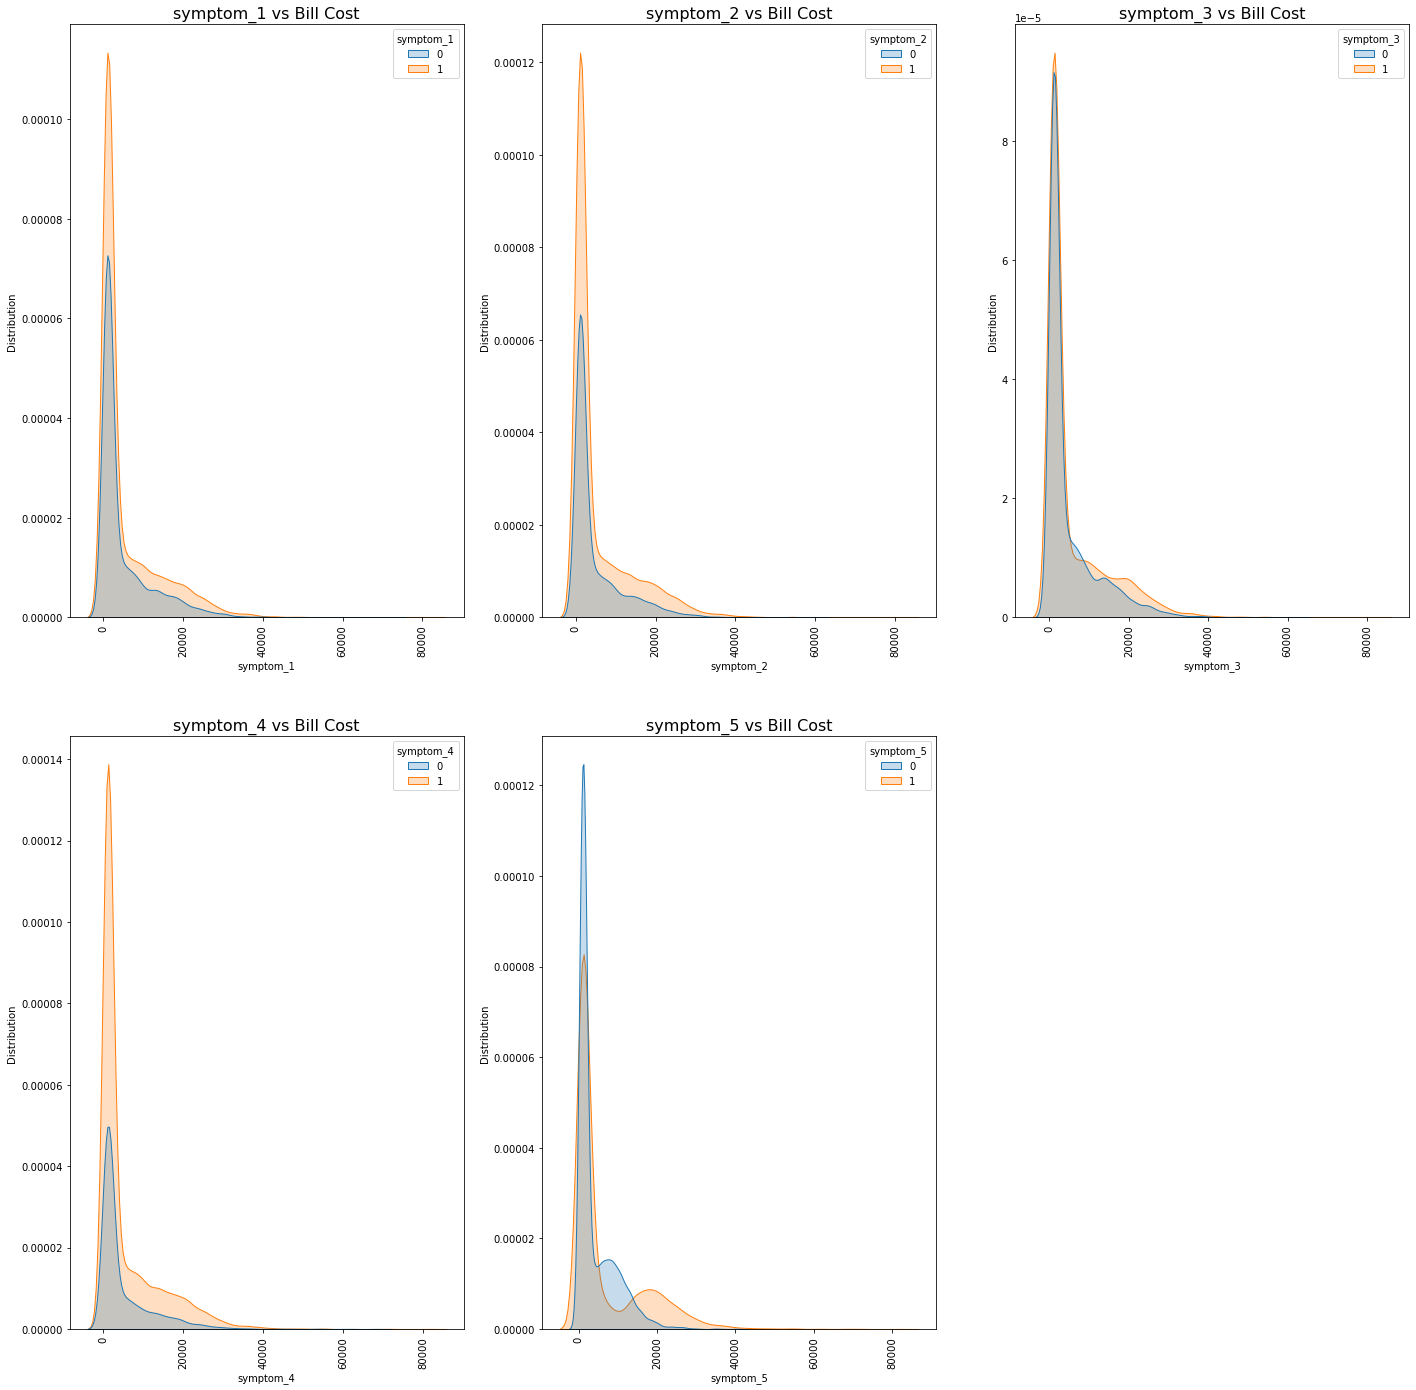

In [40]:
# Exploring Symptom on all dataset

EDA_subplot(2,3 , symptom , df_main)

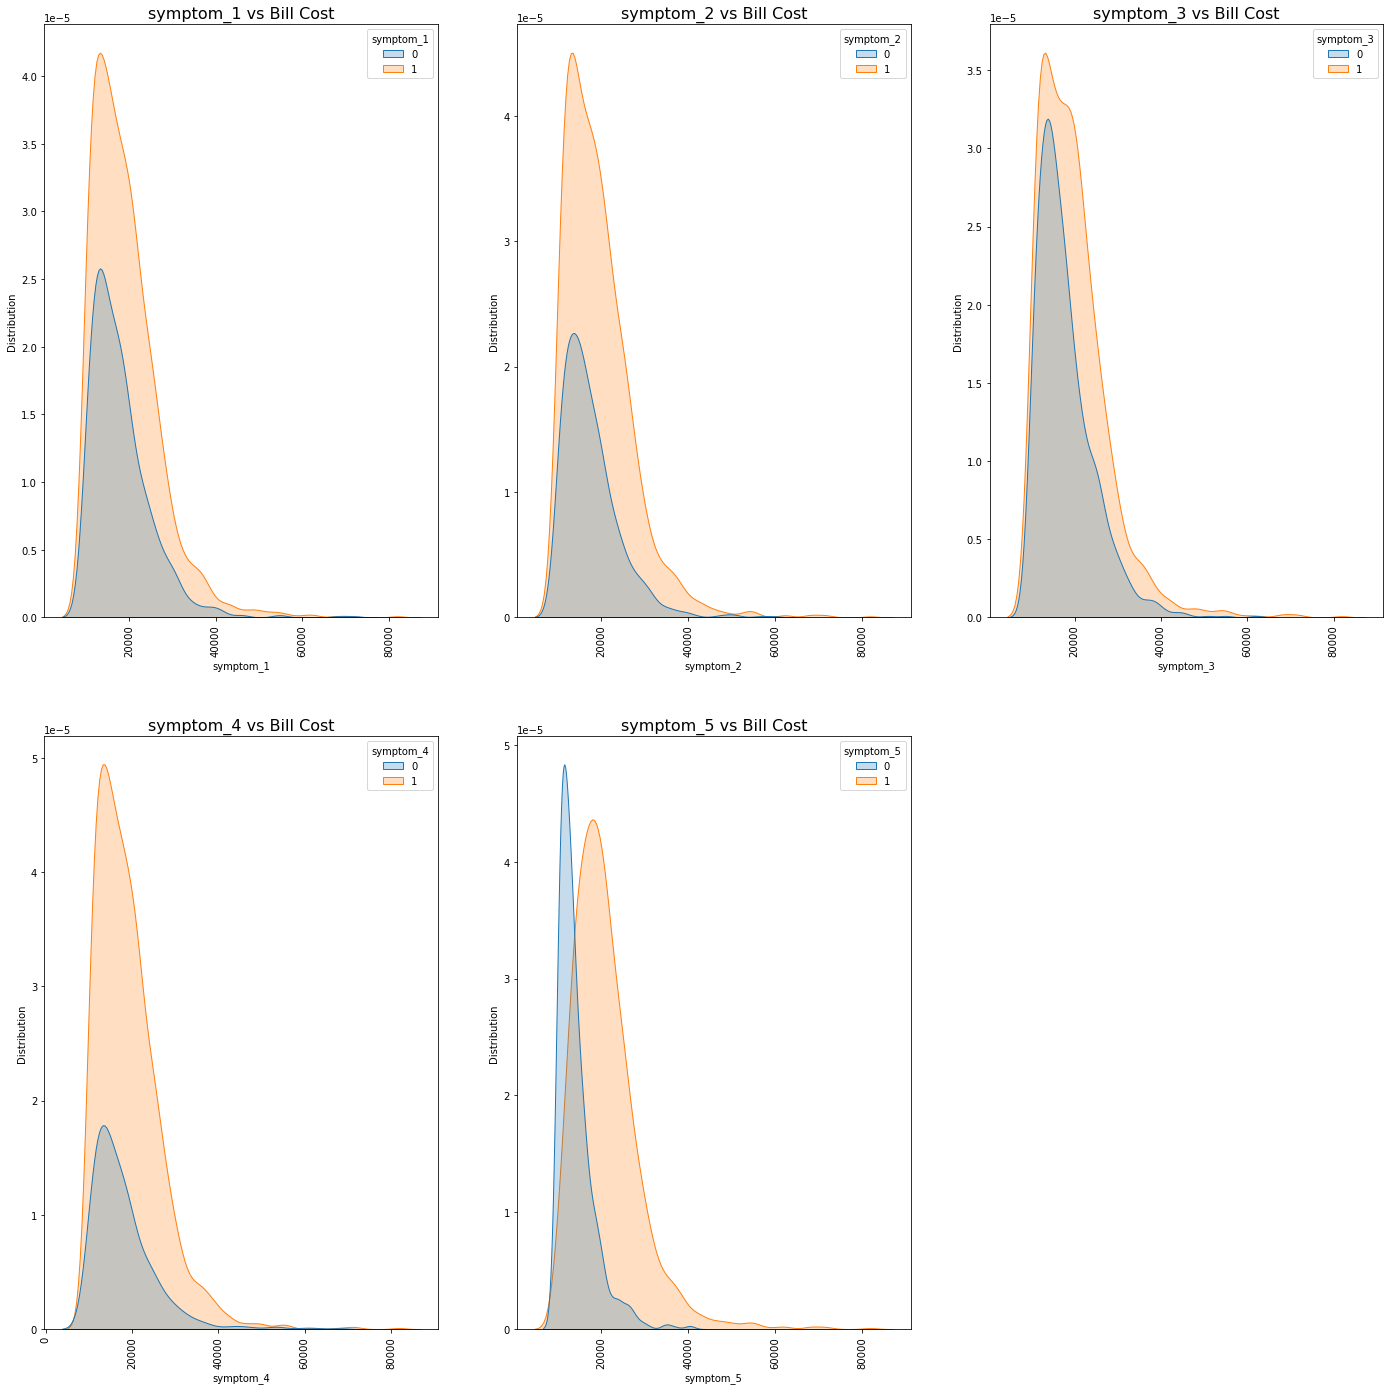

In [41]:
# Exploring Symptom on top 20th percentile hospital bill

EDA_subplot(2,3 , symptom , df_top20)

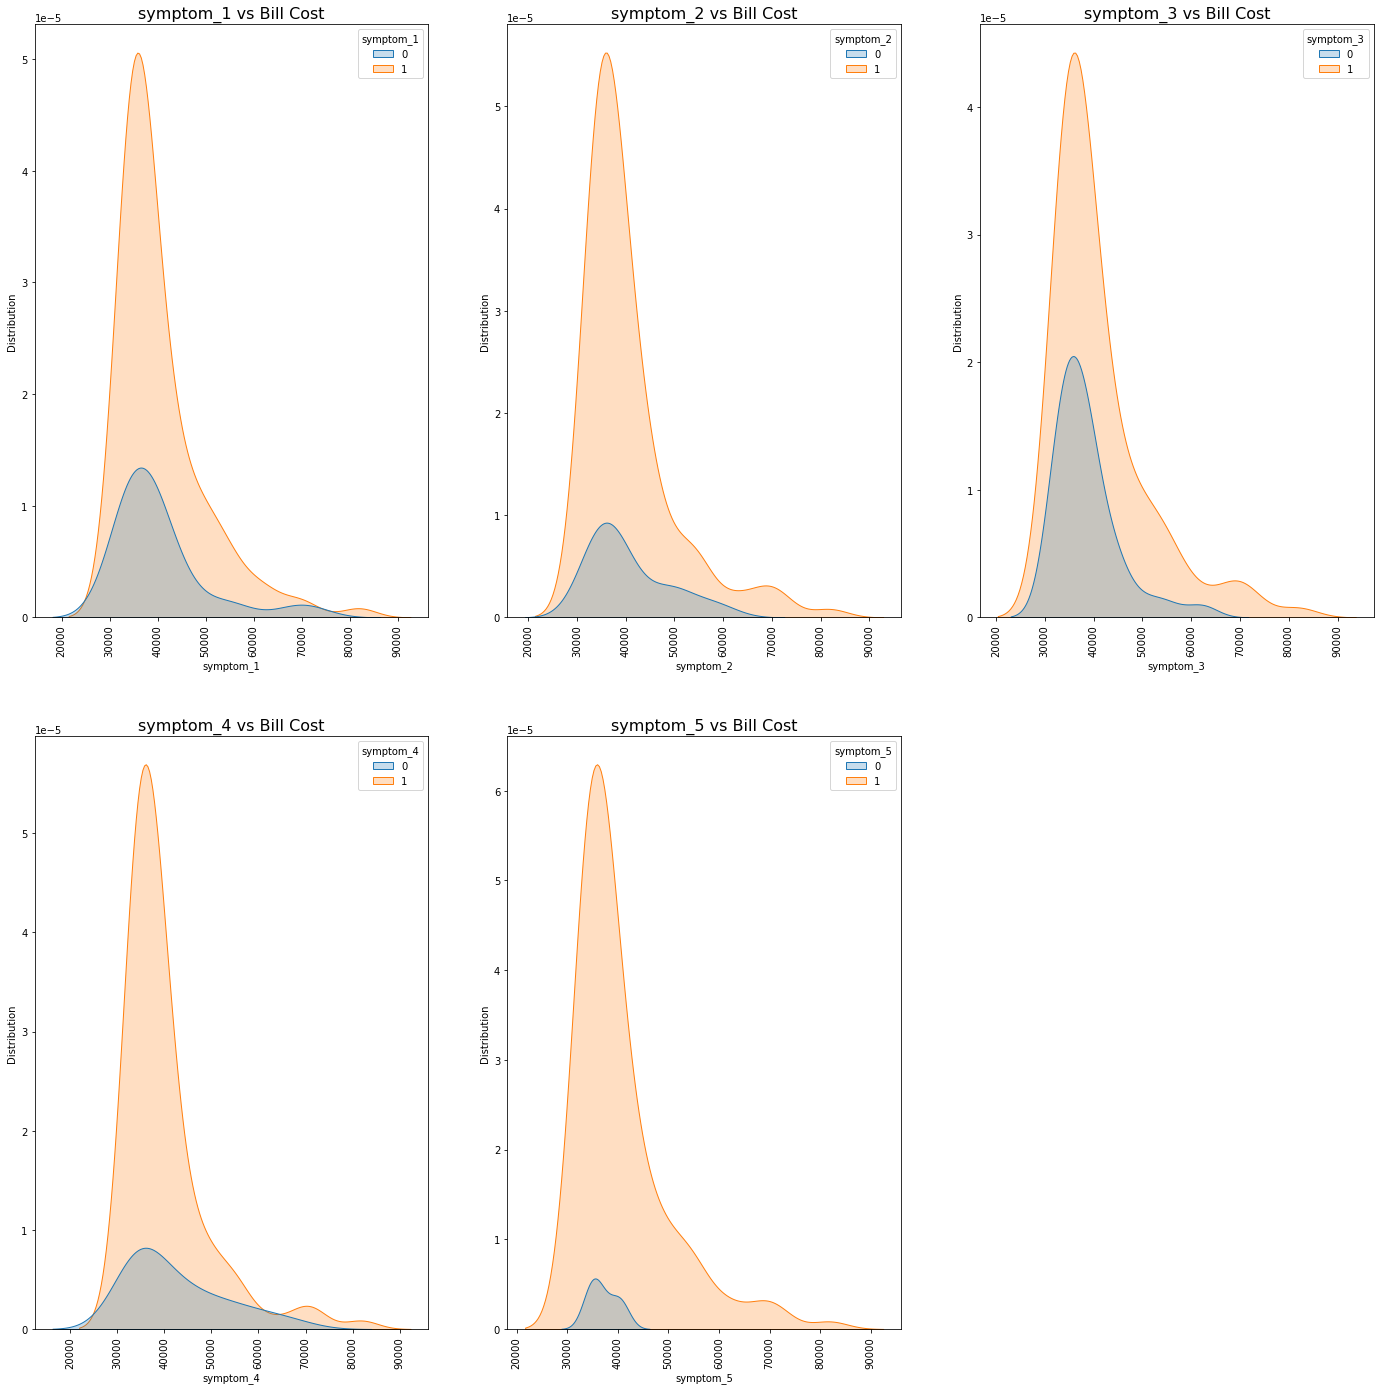

In [42]:
# Exploring Symptom on top 1 percentile hospital bill

EDA_subplot(2,3 , symptom , df_top1)

In [43]:
# EDA_subplot(2,3 , preop_med , df_main)

In [44]:
# EDA_subplot(2,3 , preop_med , df_top20)

In [45]:
# EDA_subplot(2,3 , preop_med , df_top1)

### 3.4 Random Forest Feature Importance (On non-group DF)
___

In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [47]:
rf = RandomForestRegressor()

In [48]:
X_train , X_test , y_train , y_test  = train_test_split(X , y , random_state = 42 , train_size=0.8)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [49]:
rf.fit(X_train , y_train)

RandomForestRegressor()

In [50]:
# eval_pred(rf , X_train , X_test)

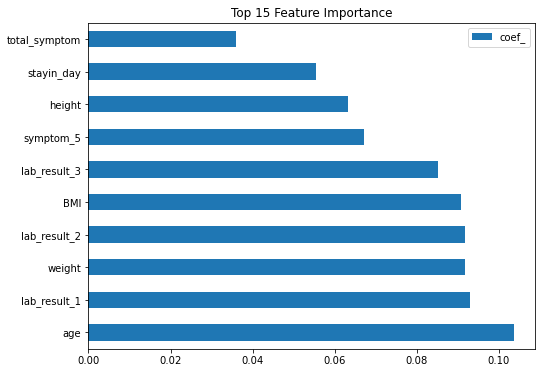

In [51]:
df = pd.DataFrame(index= X.columns,
                  data = {'coef_' :rf.feature_importances_})
df.sort_values(by = 'coef_' , ascending = False).head(10).plot(kind = 'barh' , figsize = (8,6))
plt.title('Top 15 Feature Importance');

# 4.0 Next Steps
<a id = 'section4'></a>
[back to top](#top)
___

- Could we have fine tune our ML model to get a better score so that the feature importance could be a more accurate indicator? Prelim exploration had yield better results by grouping the patient ID together. The non group patient ID did not give a better score because it originate back to how the patient bill is being generated. A single patient visit generate 4 different bill with mostly the same clinical data , thus the model might be confused with regards to a bill vs the patient id.

- Could we have perform clustering on the grouped dataset and explore further? Initial studies using PCA on the non-group patient ID had not yield very meaningful clusters.

In [52]:
# Model is overfit and could be further finetuned

X = df_group.drop(['amount' , 'bill_id'] , axis = 1)
y = df_group['amount']

X_train , X_test , y_train , y_test  = train_test_split(X , y , random_state = 42 , train_size=0.7)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

rf.fit(X_train , y_train)

eval_pred(rf , X_train , X_test)

,Score
Training MAE,2690.334075
Validation MAE,7023.345091
Training RMSE,4057.933176
Validation RMSE,10421.382065
Training Model Score,0.914656
Validation Model Score,0.424155
